# Comparions

## Environments
![The deadlock environment](media/reset_and_deadlock.png)

## Results

In [1]:
from utils.plot import plot_train_summary

import matplotlib.pyplot as plt
%matplotlib inline

### Reset Environment

/tmp/ipykernel_2648029/1255602746.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2648029/1255602746.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2648029/1255602746.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2648029/1255602746.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2648029/1255602746.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2648029/1255602

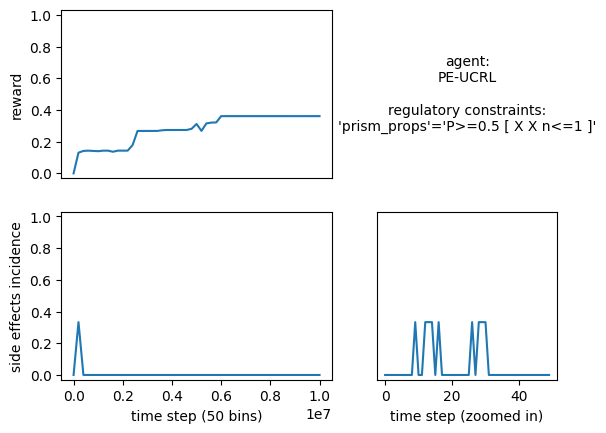

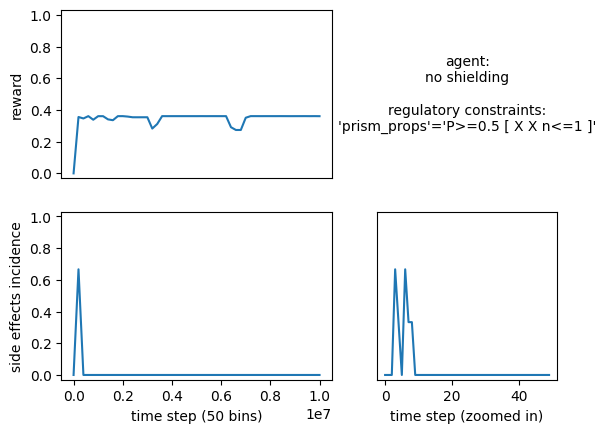

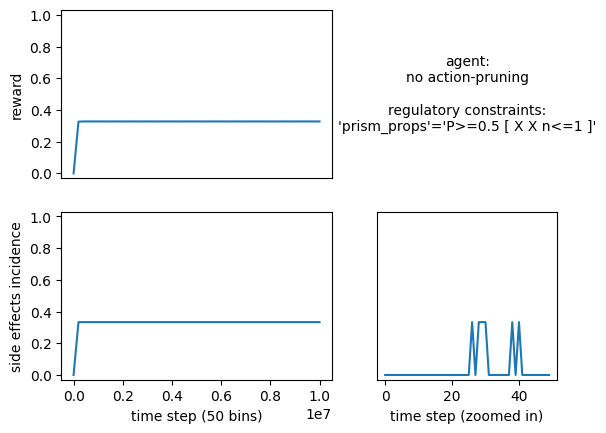

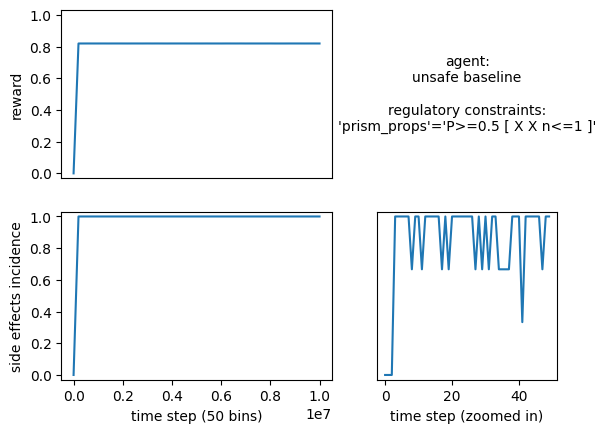

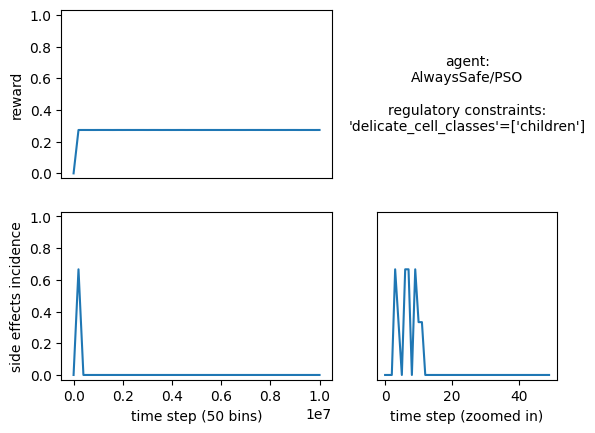

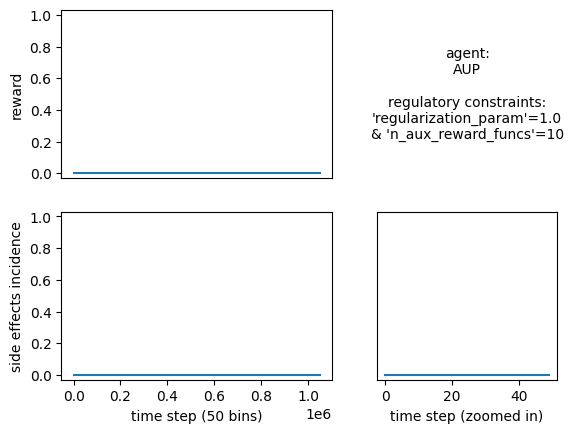

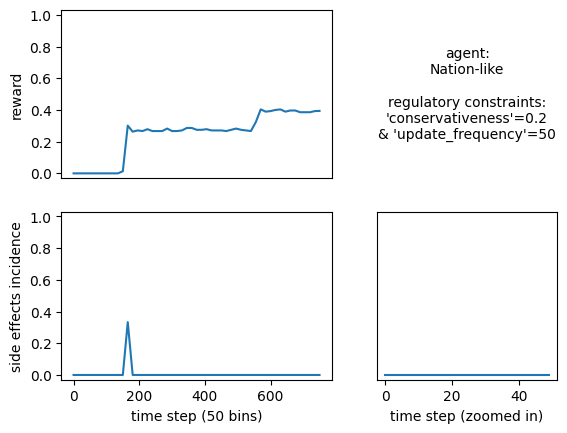

In [2]:
for i in [0, 1, 2, 3, 4, 5, 6]:
    path = 'results/partial_reset_and_deadlock/' + str(i) + '/'
    fig = plot_train_summary(path, rmax=1.0)
    fig.show()

### Deadlock Environment

/tmp/ipykernel_2648029/3909938507.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2648029/3909938507.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2648029/3909938507.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2648029/3909938507.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2648029/3909938507.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2648029/3909938

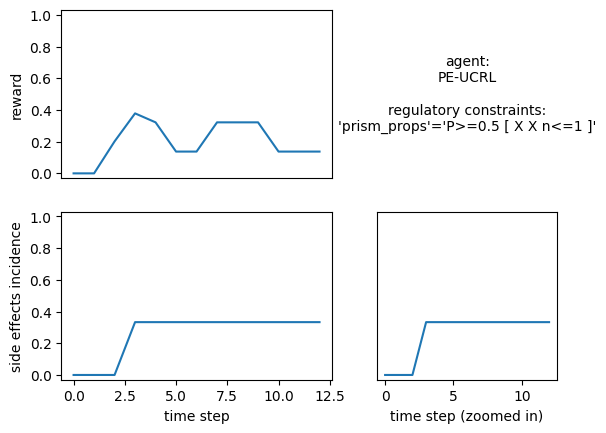

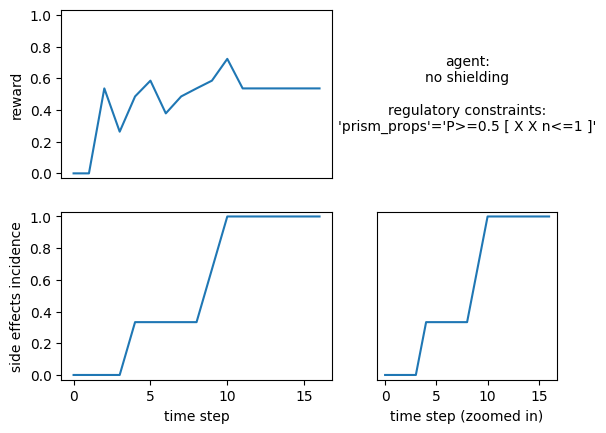

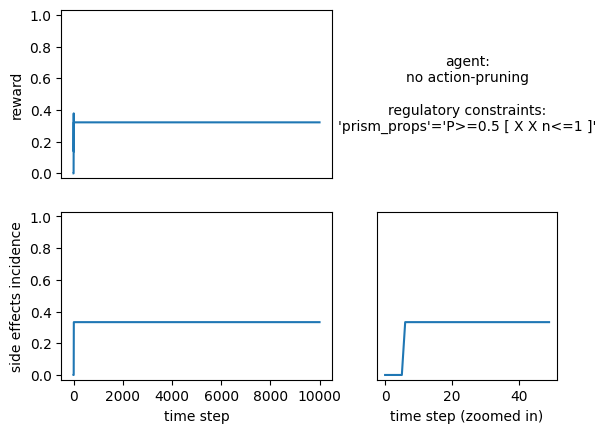

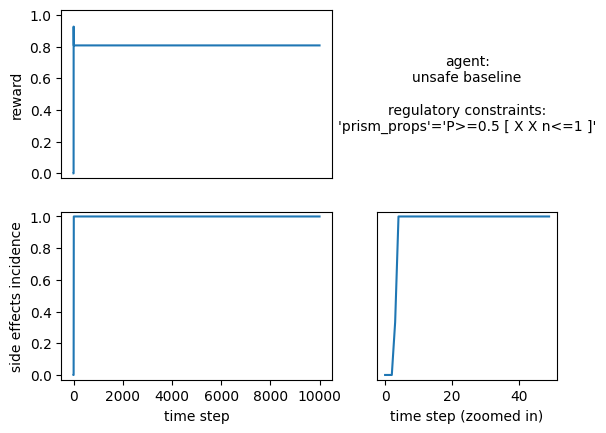

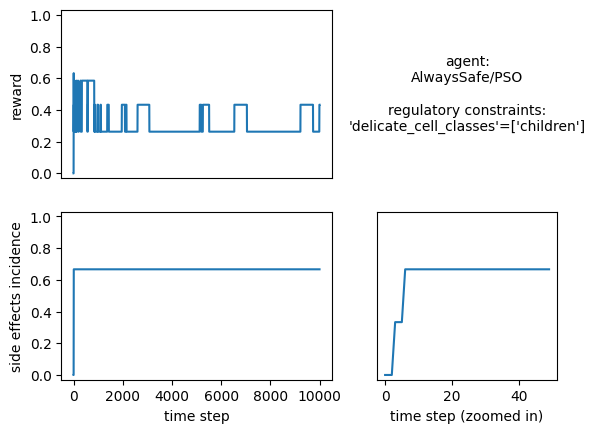

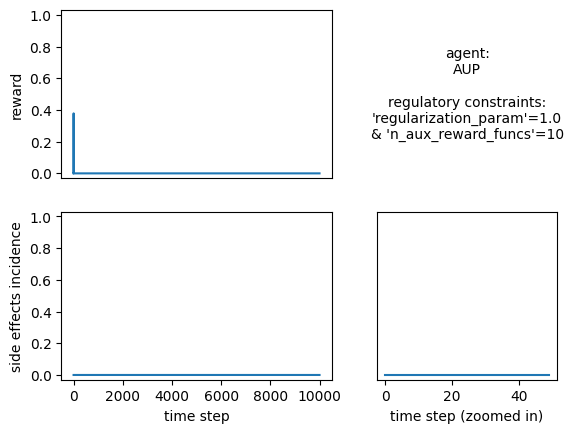

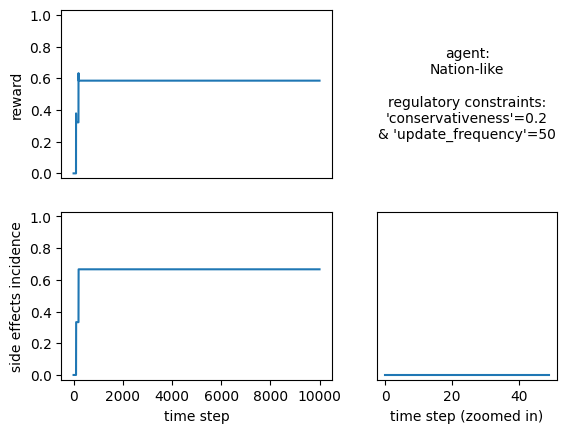

In [3]:
for i in [7, 8, 9, 10, 11, 12, 13]:
    path = 'results/partial_reset_and_deadlock/' + str(i) + '/'
    fig = plot_train_summary(path, rmax=1.0, n_bins=None)
    fig.show()